# Fetal Brain Image Processing PIpeline

1. Setting up the root directory and file paths


In [1]:
import sys
print("Python:", sys.version)
#!pip list | grep -E "numpy|pandas|torch|monai"
!pip list | findstr "numpy pandas torch monai"

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
/bin/bash: line 1: findstr: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [1]:
!pip install --upgrade "numpy==1.26.4" "pandas<2.3" "torch==2.5.1" "monai==1.5.0"

In [1]:
#!pip install --upgrade --force-reinstall numpy  # Fix binary incompatibility
!pip install monai[all]  # Reinstall MONAI with all dependencies
from monai.config import print_config
print_config()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
!pip install monai nibabel  # nibabel is for handling neuroimaging files (e.g., .nii)

In [26]:
root_path = 'data/'  # Use absolute path
# Specify the NIfTI file path
file_path = 'DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12.nii'

2. Loading the NIfTI file


In [6]:
sub1 = nib.load(root_path + file_path)  # Returns a NIfTI image object

Importing necessary libraries

In [7]:
!pip install --upgrade monai

In [56]:
import os  # For file/directory operations
import nibabel as nib  # Required for NIfTI file handling
import sys
import numpy as np  # For numerical operations
from glob import glob  # For file path pattern matching
import SimpleITK as sitk
from monai.networks.nets import VNet
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import torch  # PyTorch for deep learning
from types import SimpleNamespace  # For creating configuration namespace

Creating a configuration object (cfg)

In [18]:
cfg = SimpleNamespace(**{})

Defining image preprocessing parameters

In [19]:
cfg.pixdim = (3.5, 3.5, 3.5)  # Voxel dimensions (mm) for resampling (x, y, z)
cfg.roi_size = [64, 64, 64]  # Region-of-interest size for model input (voxels)
cfg.sw_batch_size = 4  # Sliding window batch size for inference


6. Specifying model file and directories for MRI data and masks


In [20]:
cfg.file_pth = "fold4_train_metric_vnet.pth" # Pretrained model weights file

# Directory configuration for MRI data and masks
cfg.mri_dir = '/data'  # Directory to store MRI scans
cfg.mask_dir = '/data' # Directory to store segmentation masks
os.makedirs(cfg.mri_dir, exist_ok=True)  # Creates 'mri' directory, ignores if exists
os.makedirs(cfg.mask_dir, exist_ok=True)  # Creates 'mask' directory, ignores if exists



Initializing the VNet model

In [21]:

cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VNet(
    spatial_dims=3,          # 3D network for volumetric data (e.g., MRI/CT scans)
    in_channels=1,           # Input channels (1 for grayscale medical images)
    out_channels=2,          # Output channels (2 for binary segmentation: background + target)
    act=("elu", {"inplace": True}),  # Activation function: Exponential Linear Unit (with in-place memory optimization)
    dropout_dim=3,           # 3D dropout for regularization (prevents overfitting in 3D conv layers)
    bias=False,              # Disable bias terms in convolutional layers (often used with batch norm)
).to(cfg.device)             # Moves model to GPU/CPU based on cfg.device


In [22]:
# Load pretrained weights into the model
model.load_state_dict(
    torch.load(cfg.file_pth,  # Path to saved model weights (cfg.file_pth = "fold4_train_metric_vnet.pth")
    cfg.device)  # Ensures weights are loaded to the correct device (GPU/CPU)
)


<All keys matched successfully>

Defining preprocessing transforms

In [23]:
from monai.transforms import (
  AsDiscreted,
  Compose,
  EnsureChannelFirstd,
  Invertd,
  LoadImaged,
  NormalizeIntensityd,
  Orientationd,
  SaveImaged,
  Spacingd,
)

test_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=cfg.pixdim, mode="bilinear"),
    NormalizeIntensityd(keys="image", nonzero=True),
])


Postprocessing pipeline after prediction

In [24]:
post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True),
    SaveImaged(
        keys="pred",
        meta_keys="pred_meta_dict",
        output_dir=cfg.mask_dir,
        output_postfix="vnet",
        resample=False,
    ),
])



In [27]:
import numpy as np
# Load the NIfTI file
fmri_data_path = os.path.join(root_path, file_path)
image = nib.load(fmri_data_path)
data = image.get_fdata()

# Check if the data has the expected 4D shape
if len(data.shape) != 4:
    raise ValueError("Invalid shape of fMRI file format. Expected 4D shape: [x, y, z, t]")

# Split along the last axis (time dimension)
channel_list = np.split(data, data.shape[-1], axis=-1)

# Extract the base file name without extension
fmri_data_name = os.path.basename(file_path).replace(".nii", "")

# Define output directory
output_dir = os.path.join(root_path, "processed_nifti")
os.makedirs(output_dir, exist_ok=True)

# Save each time point as a separate NIfTI file
for i, channel in enumerate(channel_list):
    channel_image = nib.Nifti1Image(channel, image.affine)
    channel_file_name = os.path.join(output_dir, f"{fmri_data_name}_{i+1}.nii.gz")
    nib.save(channel_image, channel_file_name)

print(f"Processed fMRI data saved in: {output_dir}")

Processed fMRI data saved in: data/processed_nifti


## Setup and File Collection

In [28]:
# Directory where 3D NIfTI volumes are saved
fmri_dir = "data/processed_nifti"

# Collect all *.nii.gz files
test_files = []
fmri_files = glob(os.path.join(fmri_dir, "*.nii.gz"))

# Create a list of dictionaries expected by MONAI Dataset
for f_file in fmri_files:
    test_files.append({"image": f_file})

print(test_files)  # Sanity check: Print all test cases


[{'image': 'data/processed_nifti/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_2.nii.gz'}, {'image': 'data/processed_nifti/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_3.nii.gz'}, {'image': 'data/processed_nifti/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_1.nii.gz'}]


In [29]:
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset, decollate_batch

# Apply the same preprocessing transforms as defined earlier
test_ds = Dataset(data=test_files, transform=test_transforms)

# Use DataLoader to load one image at a time
test_loader = DataLoader(test_ds, batch_size=1)



In [30]:
with torch.no_grad():
  for test_data in test_loader:
    test_inputs = test_data["image"].to(cfg.device)

    # Apply sliding window inference
    test_data["pred"] = sliding_window_inference(
      test_inputs,             # Input tensor [1, C, H, W, D]
      cfg.roi_size,            # Patch size (e.g., [96, 96, 96])
      cfg.sw_batch_size,       # Sub-batch size for memory management
      model                    # Trained model
    )

    # Apply post-processing steps: invert transforms, argmax, save
    test_data = [post_transforms(i) for i in decollate_batch(test_data)]


2025-06-26 10:48:23,964 INFO image_writer.py:197 - writing: /data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_2/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_2_vnet.nii.gz
2025-06-26 10:48:39,028 INFO image_writer.py:197 - writing: /data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_3/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_3_vnet.nii.gz
2025-06-26 10:48:54,553 INFO image_writer.py:197 - writing: /data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_1/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_1_vnet.nii.gz


In [31]:
# Loop through each 4D fMRI file in the list
for fmri_data in fmri_files:
    # Load the 4D fMRI image
    image = nib.load(fmri_data)
    data = image.get_fdata()

    # Ensure input is truly 4D
    if data.ndim != 4:
        raise ValueError(f"{fmri_data} is not a 4D image.")

    # Extract the base filename and remove trailing timepoint index (_1, _2, etc.)
    fmri_data_stem = os.path.basename(fmri_data).replace(".nii.gz", "")
    fmri_data_base = "_".join(fmri_data_stem.split("_")[:-1])  # removes last part like '_1'

    # Initialize an empty array to hold all timepoint masks
    mask_data = np.zeros_like(data)

    # Loop through each timepoint
    for i in range(data.shape[-1]):
        # Construct expected file path for the i-th timepoint mask
        i_mask_dir = os.path.join(cfg.mask_dir, f"{fmri_data_base}_{i+1}")
        i_mask_file = os.path.join(i_mask_dir, f"{fmri_data_base}_{i+1}_vnet.nii.gz")

        # Check that the mask file exists
        if not os.path.exists(i_mask_file):
            raise FileNotFoundError(f"Missing mask file: {i_mask_file}")

        # Load and insert the timepoint mask into the 4D array
        i_mask_data = nib.load(i_mask_file).get_fdata()

        # Safety check: ensure shape match (should be 3D)
        if i_mask_data.ndim != 3:
            raise ValueError(f"Mask at {i_mask_file} is not 3D.")

        mask_data[..., i] = i_mask_data

    # Combine into one 4D NIfTI image using the fMRI metadata
    fmri_mask = nib.Nifti1Image(mask_data, affine=image.affine, header=image.header)

    # Define final output name for combined mask
    output_mask_name = f"{fmri_data_base}_vnet.nii.gz"

    # Save it in the same folder as the original fMRI or elsewhere
    nib.save(fmri_mask, os.path.join(root_path, output_mask_name))

    print(f"Saved combined 4D mask to: {os.path.join(root_path, output_mask_name)}")


Saved combined 4D mask to: data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_vnet.nii.gz
Saved combined 4D mask to: data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_vnet.nii.gz
Saved combined 4D mask to: data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_vnet.nii.gz


In [32]:
# Corrected paths to the files
root_path = 'data/processed_nifti/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_1.nii.gz'
#root_path = 'data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12.nii'

root_path2 = 'data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12_vnet.nii.gz'

# Load original fMRI and mask
fmri_img = nib.load(root_path)
mask_img = nib.load(root_path2)

In [33]:
# Get data arrays
fmri_data = fmri_img.get_fdata()  # [x, y, z, t]
mask_data = mask_img.get_fdata()  # Should be [x, y, z, t]

# If mask is 3D, repeat to match fMRI shape
if mask_data.ndim == 3:
    mask_data = np.repeat(mask_data[..., np.newaxis], fmri_data.shape[-1], axis=-1)

# Print debug info
print("fMRI shape:", fmri_data.shape)
print("Mask shape:", mask_data.shape)
print("fMRI affine:\n", fmri_img.affine)
print("Mask affine:\n", mask_img.affine)

fMRI shape: (240, 240, 32, 1)
Mask shape: (240, 240, 32, 1)
fMRI affine:
 [[-8.95138741e-01  5.60760163e-02  1.32673979e+00  1.20291832e+02]
 [ 2.22203940e-01  9.16157246e-01  1.00076663e+00 -1.55672882e+02]
 [ 3.86460900e-01 -3.96877080e-01  2.49764442e+00 -8.95723724e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mask affine:
 [[-8.95138741e-01  5.60760163e-02  1.32673979e+00  1.20291832e+02]
 [ 2.22203940e-01  9.16157246e-01  1.00076663e+00 -1.55672882e+02]
 [ 3.86460900e-01 -3.96877080e-01  2.49764442e+00 -8.95723724e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
!pip install matplotlib --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 190.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 141.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 258.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 215.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 261.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 212.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 195.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 231.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 241.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 245.6 MB/s eta 0:00:00
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uni

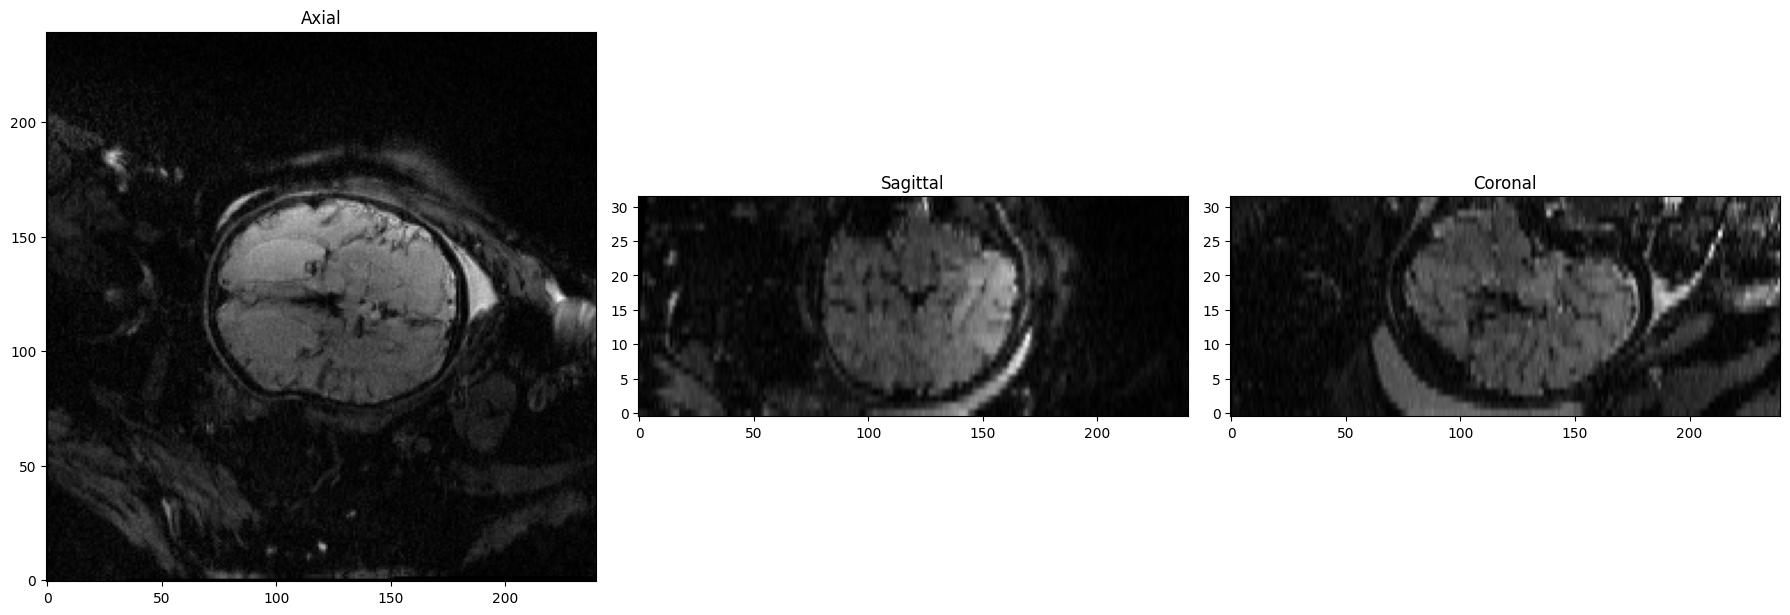

In [44]:
%matplotlib inline
#import nibabel as nib
#import nilearn as nil
import matplotlib.pyplot as plt
#from nilearn.plotting import plot_epi

# Define slices for visualization
timepoint = 0
axial_slice = fmri_data.shape[2] // 2
sagittal_slice = fmri_data.shape[0] // 2
coronal_slice = fmri_data.shape[1] // 2

# Define voxel aspect ratios (adjust according to your actual spacing)
zooms = (1.0, 1.0, 3.0)
sagittal_aspect = zooms[2] / zooms[1]
coronal_aspect = zooms[2] / zooms[0]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial view
axes[0].imshow(fmri_data[:, :, axial_slice, timepoint].T,
               cmap='gray', origin='lower', aspect=1.0)

axes[0].set_title('Axial')

# Sagittal view
axes[1].imshow(fmri_data[sagittal_slice, :, :, timepoint].T,
               cmap='gray', origin='lower', aspect=sagittal_aspect)

axes[1].set_title('Sagittal')

# Coronal view
axes[2].imshow(fmri_data[:, coronal_slice, :, timepoint].T,
               cmap='gray', origin='lower', aspect=coronal_aspect)

axes[2].set_title('Coronal')

plt.tight_layout()
plt.show()


In [59]:
zooms = (1.0, 1.0, 3.0)
sagittal_aspect = zooms[2] / zooms[1]
coronal_aspect = zooms[2] / zooms[0]

# Handle 4D or 3D
has_time = fmri_data.ndim == 4
T = fmri_data.shape[3] if has_time else 1

# Dimensions
X, Y, Z = fmri_data.shape[:3]

# Compute aspect ratios
sagittal_aspect = zooms[2] / zooms[1]
coronal_aspect = zooms[2] / zooms[0]
axial_aspect = zooms[1] / zooms[0]

# Create sliders
sag_slider = widgets.IntSlider(value=X//2, min=0, max=X-1, description='Sagittal')
cor_slider = widgets.IntSlider(value=Y//2, min=0, max=Y-1, description='Coronal')
axi_slider = widgets.IntSlider(value=Z//2, min=0, max=Z-1, description='Axial')
t_slider = widgets.IntSlider(value=0, min=0, max=T-1, description='Time') if has_time else widgets.fixed(0)

@widgets.interact(sag=sag_slider, cor=cor_slider, axi=axi_slider, time=t_slider)
def view_slices(sag, cor, axi, time=0):
    volume = fmri_data[..., time] if has_time else fmri_data

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Sagittal (X fixed)
    axes[0].imshow(volume[sag, :, :].T, cmap='gray', origin='lower', aspect=sagittal_aspect)
    axes[0].set_title(f"Sagittal (x={sag})")

    # Coronal (Y fixed)
    axes[1].imshow(volume[:, cor, :].T, cmap='gray', origin='lower', aspect=coronal_aspect)
    axes[1].set_title(f"Coronal (y={cor})")

    # Axial (Z fixed)
    axes[2].imshow(volume[:, :, axi].T, cmap='gray', origin='lower', aspect=axial_aspect)
    axes[2].set_title(f"Axial (z={axi})")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=120, description='Sagittal', max=239), IntSlider(value=120, description=…

In [60]:
# --- Handle mask dimensionality ---
if mask_data.ndim == 3:
    mask_data = np.repeat(mask_data[..., np.newaxis], fmri_data.shape[-1], axis=-1)

# --- Extract metadata ---
zooms = fmri_img.header.get_zooms()[:3]
T = fmri_data.shape[3]

# --- Aspect ratios ---
sagittal_aspect = zooms[2] / zooms[1]
coronal_aspect = zooms[2] / zooms[0]
axial_aspect = zooms[1] / zooms[0]

X, Y, Z = fmri_data.shape[:3]

# --- Interactive Sliders ---
sag_slider = widgets.IntSlider(value=X//2, min=0, max=X-1, description='Sagittal')
cor_slider = widgets.IntSlider(value=Y//2, min=0, max=Y-1, description='Coronal')
axi_slider = widgets.IntSlider(value=Z//2, min=0, max=Z-1, description='Axial')
time_slider = widgets.IntSlider(value=0, min=0, max=T-1, description='Time')

@widgets.interact(sag=sag_slider, cor=cor_slider, axi=axi_slider, time=time_slider)
def view_overlay(sag, cor, axi, time):
    vol = fmri_data[..., time]
    mask = mask_data[..., time] > 0.5  # Threshold for binary mask

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- Sagittal ---
    axes[0].imshow(vol[sag, :, :].T, cmap='gray', origin='lower', aspect=sagittal_aspect)
    axes[0].imshow(mask[sag, :, :].T, cmap='Reds', alpha=0.3, origin='lower', aspect=sagittal_aspect)
    axes[0].set_title(f"Sagittal (x={sag})")

    # --- Coronal ---
    axes[1].imshow(vol[:, cor, :].T, cmap='gray', origin='lower', aspect=coronal_aspect)
    axes[1].imshow(mask[:, cor, :].T, cmap='Reds', alpha=0.3, origin='lower', aspect=coronal_aspect)
    axes[1].set_title(f"Coronal (y={cor})")

    # --- Axial ---
    axes[2].imshow(vol[:, :, axi].T, cmap='gray', origin='lower', aspect=axial_aspect)
    axes[2].imshow(mask[:, :, axi].T, cmap='Reds', alpha=0.3, origin='lower', aspect=axial_aspect)
    axes[2].set_title(f"Axial (z={axi})")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=120, description='Sagittal', max=239), IntSlider(value=120, description=…

## Apply N4 Bias Correction

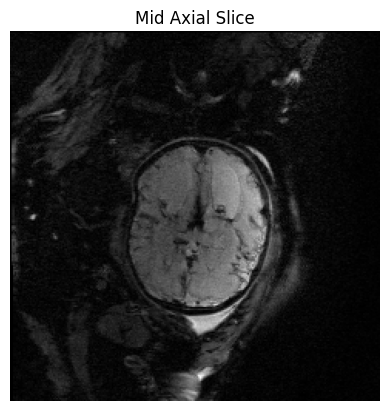

In [51]:
# Load 4D NIfTI
nib_img = nib.load(root_path)
nib_data = nib_img.get_fdata()

# If 4D, take the first volume
if nib_data.ndim == 4:
    nib_data = nib_data[..., 0]

# Convert to SimpleITK image
sitk_img = sitk.GetImageFromArray(nib_data.astype(np.float32))

# Fix spacing conversion
spacing = [float(s) for s in nib_img.header.get_zooms()[:3]]
sitk_img.SetSpacing(spacing)

# Optional: view a slice
mid_slice = nib_data.shape[2] // 2
plt.imshow(nib_data[:, :, mid_slice], cmap='gray')
plt.title("Mid Axial Slice")
plt.axis("off")
plt.show()


## Code for N4 Bias Field Correction


In [48]:
# Create mask from intensity threshold (simple binary brain mask)
sitk_mask = sitk.OtsuThreshold(sitk_img, 0, 1, 200)

# Convert image to float32 for N4
sitk_img = sitk.Cast(sitk_img, sitk.sitkFloat32)

# Setup bias field corrector
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetMaximumNumberOfIterations([50, 50, 30, 20])  # More iterations

# Run correction
corrected_img = corrector.Execute(sitk_img, sitk_mask)

# Optional: Visualize correction vs original
original_np = sitk.GetArrayFromImage(sitk_img)
corrected_np = sitk.GetArrayFromImage(corrected_img)



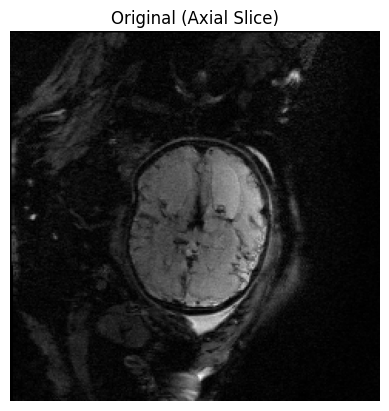

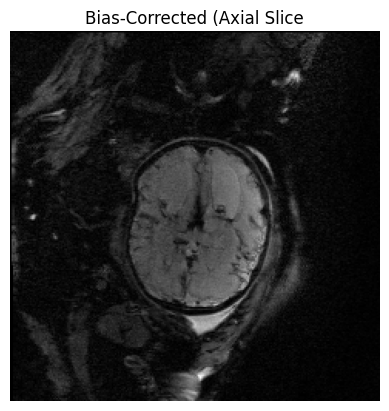

In [49]:
# Display middle slice
mid_slice = nib_data.shape[2] // 2
plt.imshow(original_np[:, :, mid_slice], cmap='gray')
plt.title("Original (Axial Slice)")
plt.axis("off")
plt.show()

# Display middle slice
mid_slice = nib_data.shape[2] // 2
plt.imshow(corrected_np[:, :, mid_slice], cmap='gray')
plt.title("Bias-Corrected (Axial Slice")
plt.axis("off")
plt.show()



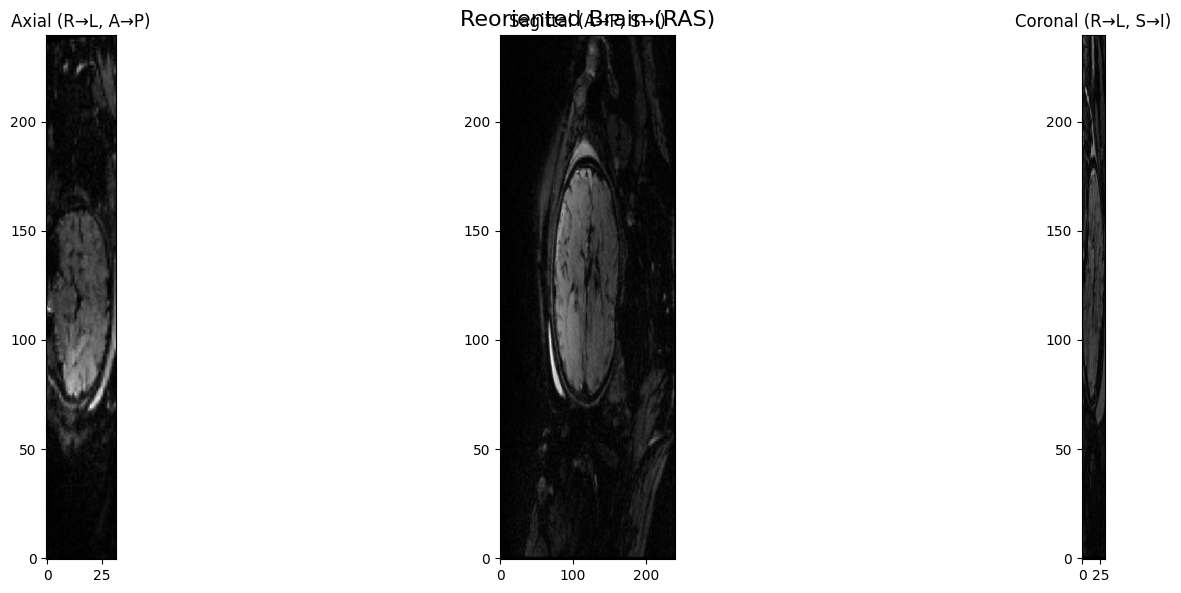

Direction cosines: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (1.0, 1.0, 3.0)


In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and convert to 3D
input_path = 'data/DICOM_ep2d_bold_1x1x3_noSMS_TE41_trans_20240524113639_12.nii'
img_4d = sitk.ReadImage(input_path)
img_3d = img_4d[:,:,:,0]  # Take first volume

# 2. Physical Reorientation to RAS
def force_ras(image):
    # Get array and metadata
    data = sitk.GetArrayFromImage(image)  # Shape: (z,y,x)
    spacing = image.GetSpacing()  # (x,y,z)
    origin = image.GetOrigin()

    # Flip axes to match RAS convention
    data_ras = np.flip(data, axis=(0,1))  # Flip Z and Y dimensions

    # Create new image with RAS orientation
    img_ras = sitk.GetImageFromArray(data_ras)
    img_ras.SetSpacing(spacing)
    img_ras.SetOrigin(origin)
    img_ras.SetDirection((1,0,0,0,1,0,0,0,1))  # Force RAS matrix
    return img_ras

img_ras = force_ras(img_3d)

# 3. Verification
print("Final direction:", img_ras.GetDirection())  # Will be (1,0,0,0,1,0,0,0,1)

# 4. Visualization
def show_ortho(img):
    size = img.GetSize()
    fig, axes = plt.subplots(1,3, figsize=(15,5))

    # Axial
    axes[0].imshow(sitk.GetArrayFromImage(img)[size[2]//2], cmap='gray')
    axes[0].set_title('Axial (R→L, A→P)')

    # Sagittal
    axes[1].imshow(sitk.GetArrayFromImage(img)[:,:,size[0]//2].T, cmap='gray')
    axes[1].set_title('Sagittal (A→P, S→I)')

    # Coronal
    axes[2].imshow(sitk.GetArrayFromImage(img)[:,size[1]//2,:].T, cmap='gray')
    axes[2].set_title('Coronal (R→L, S→I)')

    plt.tight_layout()
    plt.show()

show_ortho(img_ras)

In [ ]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

# 1. Load corrected image (from previous step)
corrected_sitk = sitk.ReadImage(corrected_path)

# 2. Apply orientation correction to RAS (Right-Anterior-Superior)
orienter = sitk.DICOMOrientImageFilter()
orienter.SetDesiredCoordinateOrientation("RAS")
reoriented_img = orienter.Execute(corrected_sitk)

# 3. Save the reoriented image
reoriented_path = "/data/reoriented_to_RAS.nii.gz"
sitk.WriteImage(reoriented_img, reoriented_path)
print("✅ Reoriented image saved to:", reoriented_path)

# 4. Visualize in all 3 planes
reoriented_np = sitk.GetArrayFromImage(reoriented_img)  # shape: [z, y, x]

# Choose middle slices for each axis
axial_slice = reoriented_np.shape[0] // 2
coronal_slice = reoriented_np.shape[1] // 2
sagittal_slice = reoriented_np.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial
axes[0].imshow(reoriented_np[axial_slice, :, :], cmap='gray')
axes[0].set_title('Axial (Z Slice)')
axes[0].axis('off')

# Coronal
axes[1].imshow(reoriented_np[:, coronal_slice, :], cmap='gray')
axes[1].set_title('Coronal (Y Slice)')
axes[1].axis('off')

# Sagittal
axes[2].imshow(reoriented_np[:, :, sagittal_slice], cmap='gray')
axes[2].set_title('Sagittal (X Slice)')
axes[2].axis('off')

plt.suptitle("Reoriented Image in RAS (Clinical) Space", fontsize=16)
plt.tight_layout()
plt.show()


TypeError: in method 'DICOMOrient', argument 1 of type 'itk::simple::Image const &'

In [ ]:


# Verify new orientation
print(reoriented_img.GetDirection())  # Should show (1,0,0,0,1,0,0,0,1)

(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)


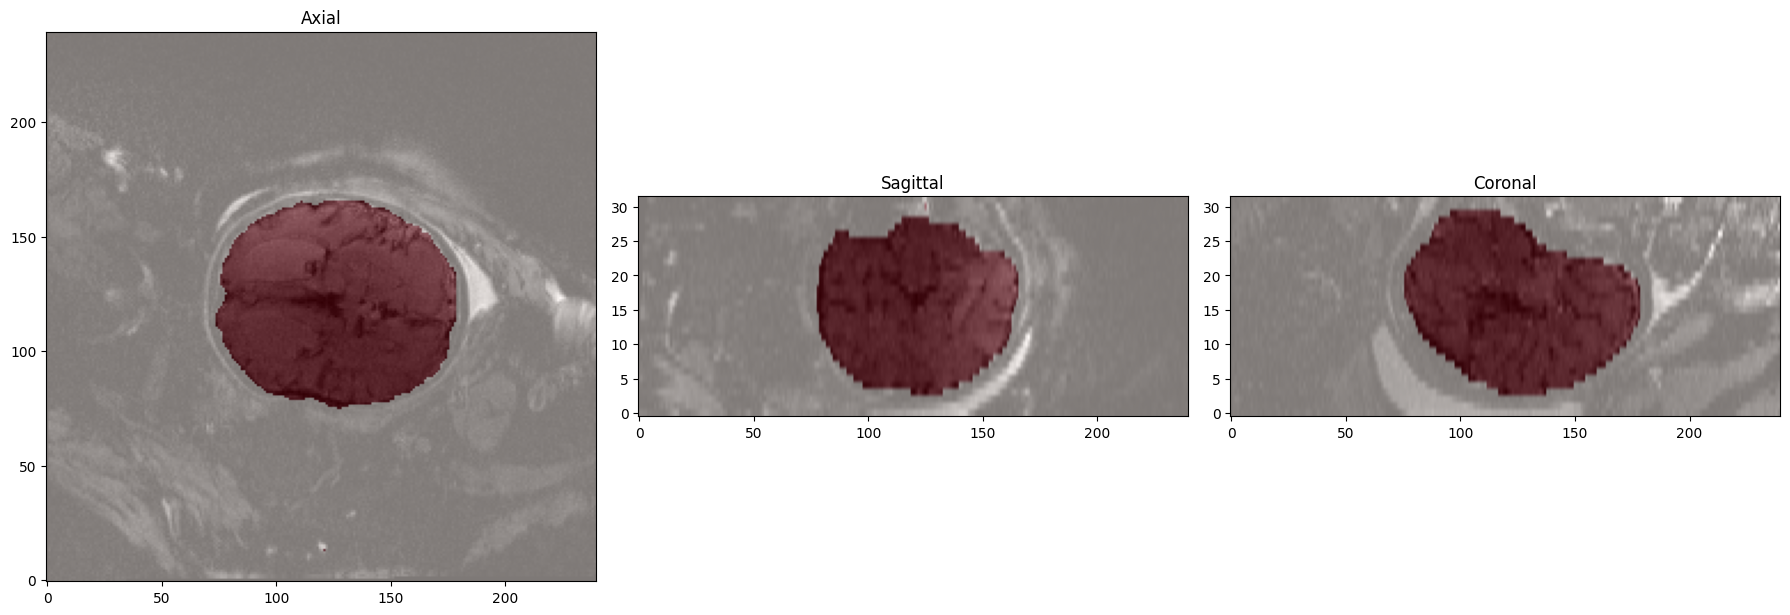

In [ ]:
%matplotlib inline
#import nibabel as nib
#import nilearn as nil
import matplotlib.pyplot as plt
#from nilearn.plotting import plot_epi

# Define slices for visualization
timepoint = 0
axial_slice = fmri_data.shape[2] // 2
sagittal_slice = fmri_data.shape[0] // 2
coronal_slice = fmri_data.shape[1] // 2

# Define voxel aspect ratios (adjust according to your actual spacing)
zooms = (1.0, 1.0, 3.0)
sagittal_aspect = zooms[2] / zooms[1]
coronal_aspect = zooms[2] / zooms[0]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial view
axes[0].imshow(fmri_data[:, :, axial_slice, timepoint].T,
               cmap='gray', origin='lower', aspect=1.0)
axes[0].imshow(mask_data[:, :, axial_slice, timepoint].T,
               cmap='Reds', alpha=0.5, origin='lower', aspect=1.0)
axes[0].set_title('Axial')

# Sagittal view
axes[1].imshow(fmri_data[sagittal_slice, :, :, timepoint].T,
               cmap='gray', origin='lower', aspect=sagittal_aspect)
axes[1].imshow(mask_data[sagittal_slice, :, :, timepoint].T,
               cmap='Reds', alpha=0.5, origin='lower', aspect=sagittal_aspect)
axes[1].set_title('Sagittal')

# Coronal view
axes[2].imshow(fmri_data[:, coronal_slice, :, timepoint].T,
               cmap='gray', origin='lower', aspect=coronal_aspect)
axes[2].imshow(mask_data[:, coronal_slice, :, timepoint].T,
               cmap='Reds', alpha=0.5, origin='lower', aspect=coronal_aspect)
axes[2].set_title('Coronal')

plt.tight_layout()
plt.show()


Cropping Masked Data

In [ ]:
def crop_to_brain_region(image_data, mask_data, padding=3):
    """
    image_data: 4D fMRI image (shape: [x, y, z, t])

    mask_data: 4D binary mask (same shape as image, shows where the brain is)

    padding: Extra space (in voxels) added around the brain region when cropping

    Crop both the image and mask to the smallest bounding box containing the brain,
    with optional padding around the edges.

    Args:
        image_data: 4D numpy array [x, y, z, t]
        mask_data: 4D numpy array [x, y, z, t]
        padding: number of voxels to add as margin around the brain

    Returns:
        cropped_image: 4D array containing only the brain region
        cropped_mask: 4D array containing only the brain region
        crop_slices: tuple of slices used for cropping (can be used for other volumes)
    """

    """
        Find Non-Zero Mask Areas:
        For each axis, we sum all values across the other dimensions.

        This tells us which slices along x/y/z contain brain voxels (non-zero mask).
    """
    # Sum along all axes to find where the mask exists
    sum_x = np.sum(mask_data, axis=(1, 2, 3))  # Sum over y,z,t
    sum_y = np.sum(mask_data, axis=(0, 2, 3))  # Sum over x,z,t
    sum_z = np.sum(mask_data, axis=(0, 1, 3))  # Sum over x,y,t

    """
        Find Bounding Box of the Brain:
        We identify the indices where brain voxels exist.

        These are the bounding edges of the brain in the mask.
    """

    # Find the first and last non-zero elements in each dimension
    x_nonzero = np.where(sum_x > 0)[0]
    y_nonzero = np.where(sum_y > 0)[0]
    z_nonzero = np.where(sum_z > 0)[0]

    """
        Error Check – No Brain Found
        If the mask contains no non-zero values, the function raises an error.
    """

    if len(x_nonzero) == 0 or len(y_nonzero) == 0 or len(z_nonzero) == 0:
        raise ValueError("No brain region found in the mask")

    """
        Calculate Crop Boundaries with Padding
        For each axis:

        Start from the first non-zero slice minus padding.

        End at the last non-zero slice plus padding.

        Clip to ensure we don't go outside image bounds.
    """
    # Calculate crop boundaries with padding
    x_start = max(0, x_nonzero[0] - padding)
    x_end = min(image_data.shape[0], x_nonzero[-1] + padding + 1)

    y_start = max(0, y_nonzero[0] - padding)
    y_end = min(image_data.shape[1], y_nonzero[-1] + padding + 1)

    z_start = max(0, z_nonzero[0] - padding)
    z_end = min(image_data.shape[2], z_nonzero[-1] + padding + 1)

    """
        slice(None) means keep all time steps (t-dimension).

        These slices define the 3D region around the brain.
    """

    # Create slices for cropping
    crop_slices = (slice(x_start, x_end),
                   slice(y_start, y_end),
                   slice(z_start, z_end),
                   slice(None))  # Keep all timepoints

    # Crop both the image and mask - Apply the slice to both image and mask to crop the region.
    cropped_image = image_data[crop_slices]
    cropped_mask = mask_data[crop_slices]

    return cropped_image, cropped_mask, crop_slices

# Apply the cropping function
cropped_fmri, cropped_mask, crop_slices = crop_to_brain_region(fmri_data, mask_data, padding=3)

print("Original fMRI shape:", fmri_data.shape)
print("Cropped fMRI shape:", cropped_fmri.shape)
print("Original mask shape:", mask_data.shape)
print("Cropped mask shape:", cropped_mask.shape)

Original fMRI shape: (240, 240, 32, 1)
Cropped fMRI shape: (170, 159, 32, 1)
Original mask shape: (240, 240, 32, 1)
Cropped mask shape: (170, 159, 32, 1)


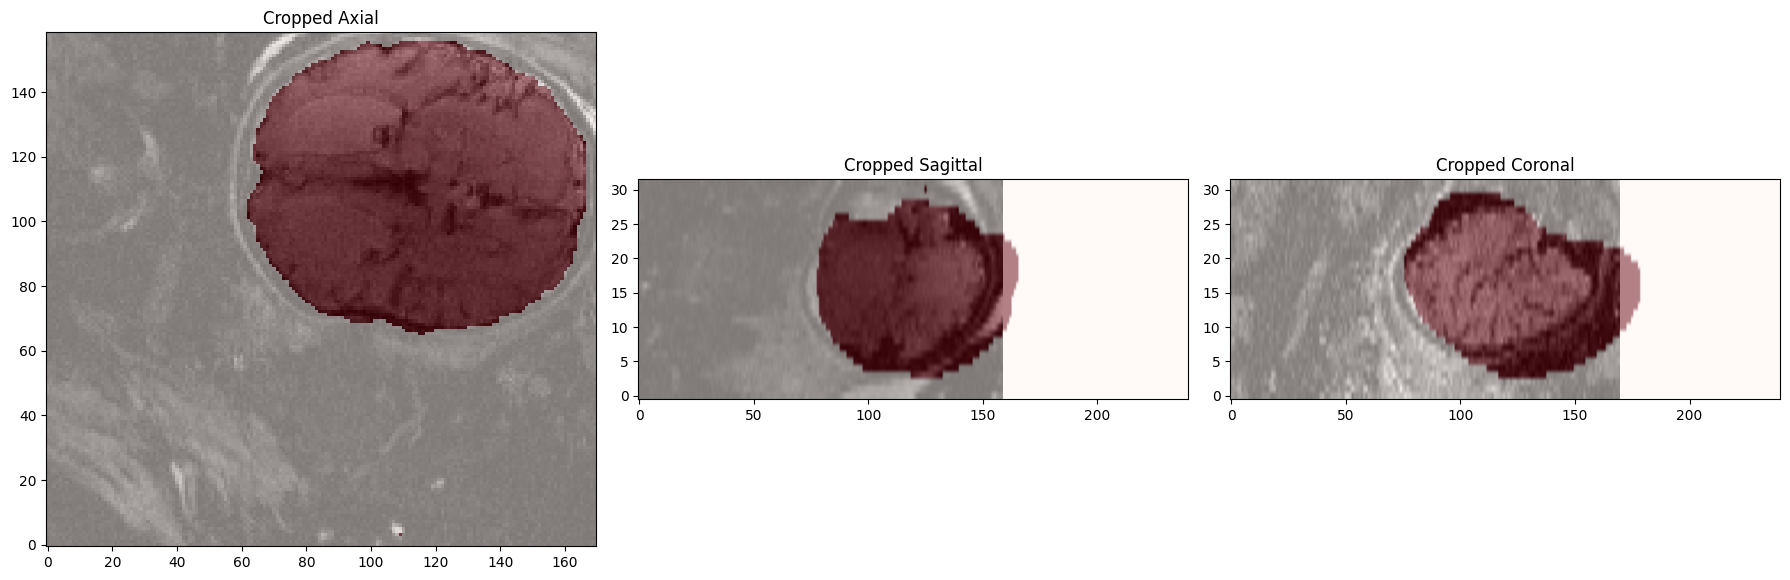

In [ ]:
# Visualize the cropped results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate middle slices for cropped data
cropped_axial = cropped_fmri.shape[2] // 2
cropped_sagittal = cropped_fmri.shape[0] // 2
cropped_coronal = cropped_fmri.shape[1] // 2

# Axial view
axes[0].imshow(cropped_fmri[:, :, cropped_axial, 0].T,
               cmap='gray', origin='lower', aspect=1.0)
axes[0].imshow(cropped_mask[:, :, cropped_axial, 0].T,
               cmap='Reds', alpha=0.5, origin='lower', aspect=1.0)
axes[0].set_title('Cropped Axial')

# Sagittal view
axes[1].imshow(cropped_fmri[cropped_sagittal, :, :, 0].T,
               cmap='gray', origin='lower', aspect=sagittal_aspect)
axes[1].imshow(mask_data[sagittal_slice, :, :, 0].T,
               cmap='Reds', alpha=0.5, origin='lower', aspect=sagittal_aspect)
axes[1].set_title('Cropped Sagittal')

# Coronal view
axes[2].imshow(cropped_fmri[:, cropped_coronal, :, 0].T,
               cmap='gray', origin='lower', aspect=coronal_aspect)
axes[2].imshow(mask_data[:, coronal_slice, :, 0].T,
               cmap='Reds', alpha=0.5, origin='lower', aspect=coronal_aspect)
axes[2].set_title('Cropped Coronal')

plt.tight_layout()
plt.show()

Apply Erosion to Cropped Image

In [ ]:
# Save the cropped images if needed
nib.save(nib.Nifti1Image(cropped_fmri, fmri_img.affine, fmri_img.header), '/data/disk_1/stu-projects/ezeji/server/processed_masks/cropped_fmri.nii.gz')
nib.save(nib.Nifti1Image(cropped_mask, mask_img.affine, mask_img.header), '/data/disk_1/stu-projects/ezeji/server/processed_masks/cropped_mask.nii.gz')

In [ ]:
from scipy.ndimage import binary_erosion, binary_dilation
def morphologically_process_mask(mask_data, operation='erode', iterations=1):
    """
    Apply morphological operations (erosion or dilation) to a binary mask.

    Args:
        mask_data: 4D numpy array [x, y, z, t], typically a brain mask
        operation: 'erode' or 'dilate'
        iterations: number of erosion/dilation steps to apply

    Returns:
        processed_mask: the mask after morphological operation
    """
    processed_mask = np.zeros_like(mask_data)

    # Loop through each timepoint to apply 3D erosion/dilation
    for t in range(mask_data.shape[3]):
        binary_mask = mask_data[..., t] > 0  # Ensure mask is boolean

        if operation == 'erode':
            processed = binary_erosion(binary_mask, iterations=iterations)
        elif operation == 'dilate':
            processed = binary_dilation(binary_mask, iterations=iterations)
        else:
            raise ValueError("Operation must be 'erode' or 'dilate'")

        processed_mask[..., t] = processed.astype(np.uint8)

    return processed_mask
eroded_mask = morphologically_process_mask(cropped_mask, operation='erode', iterations=2)
dilated_mask = morphologically_process_mask(cropped_mask, operation='dilate', iterations=2)


Performing morphological operations...


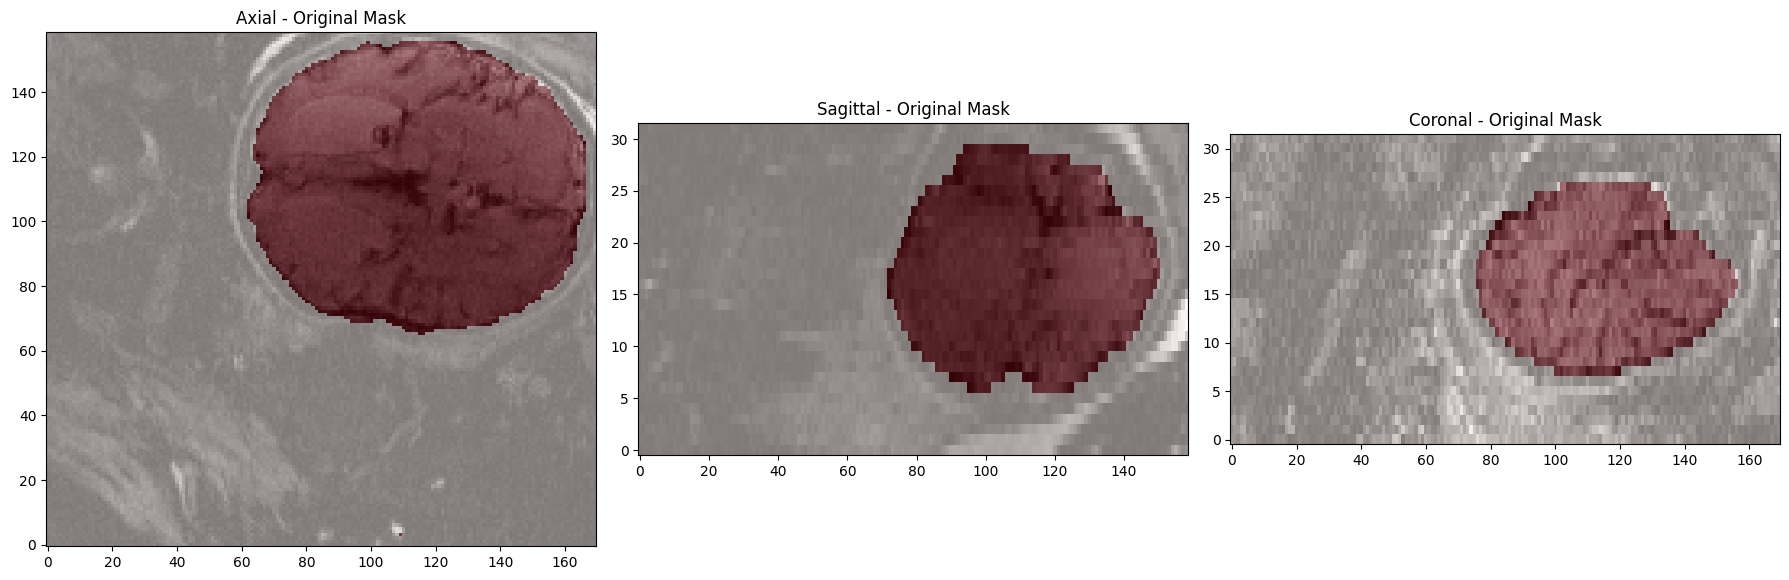

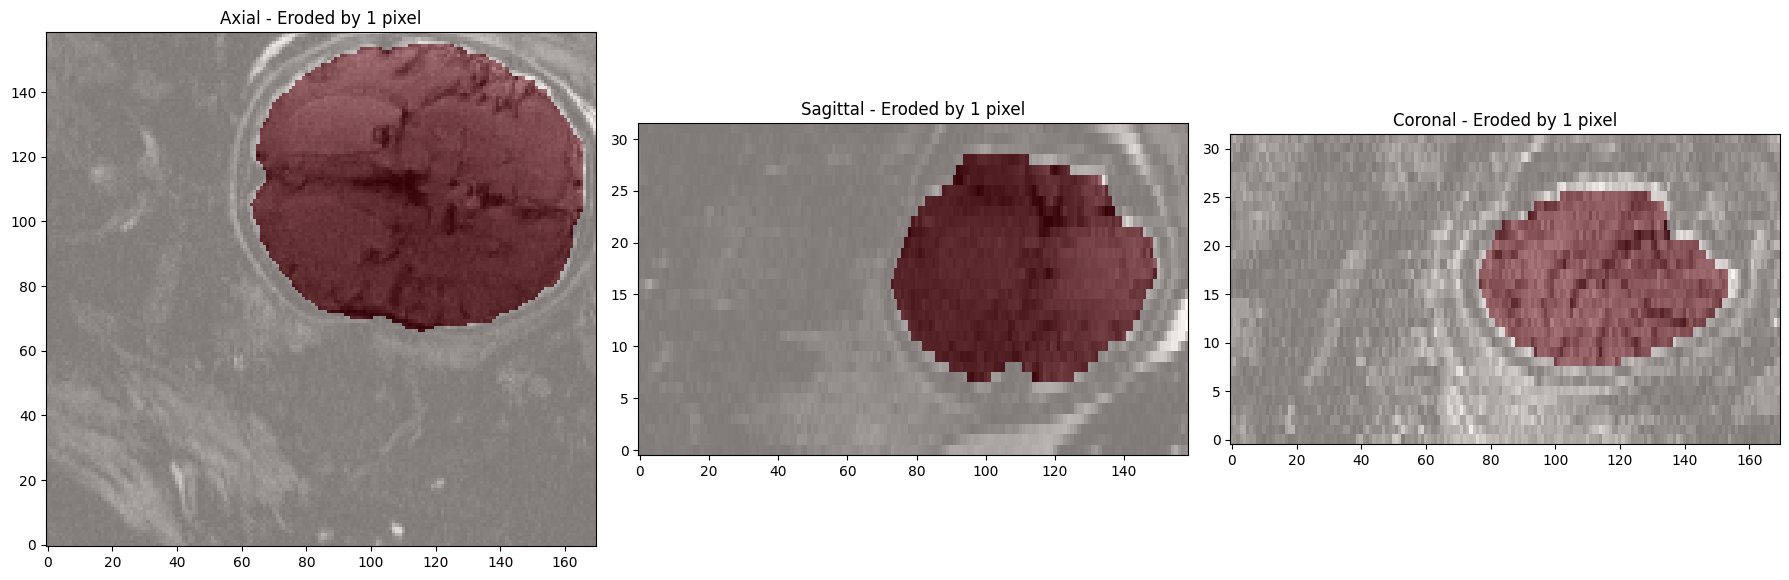

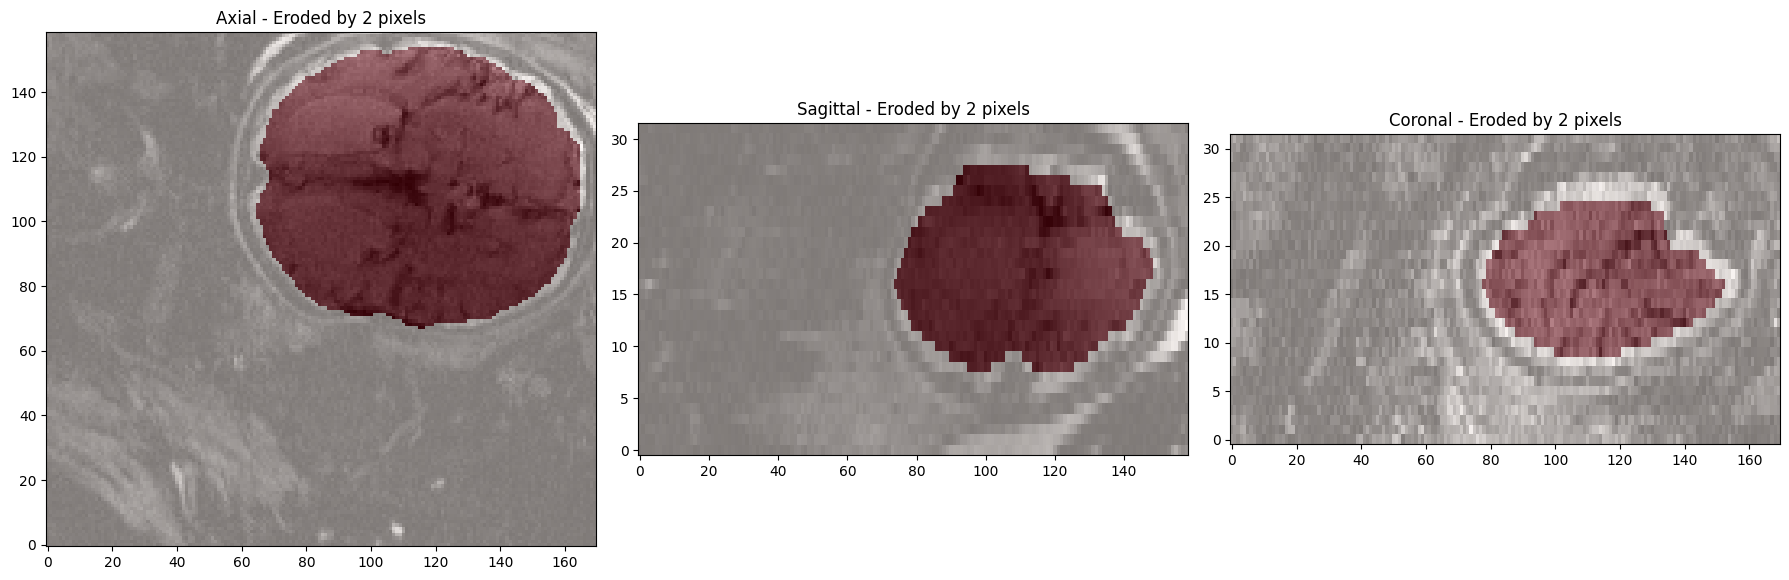

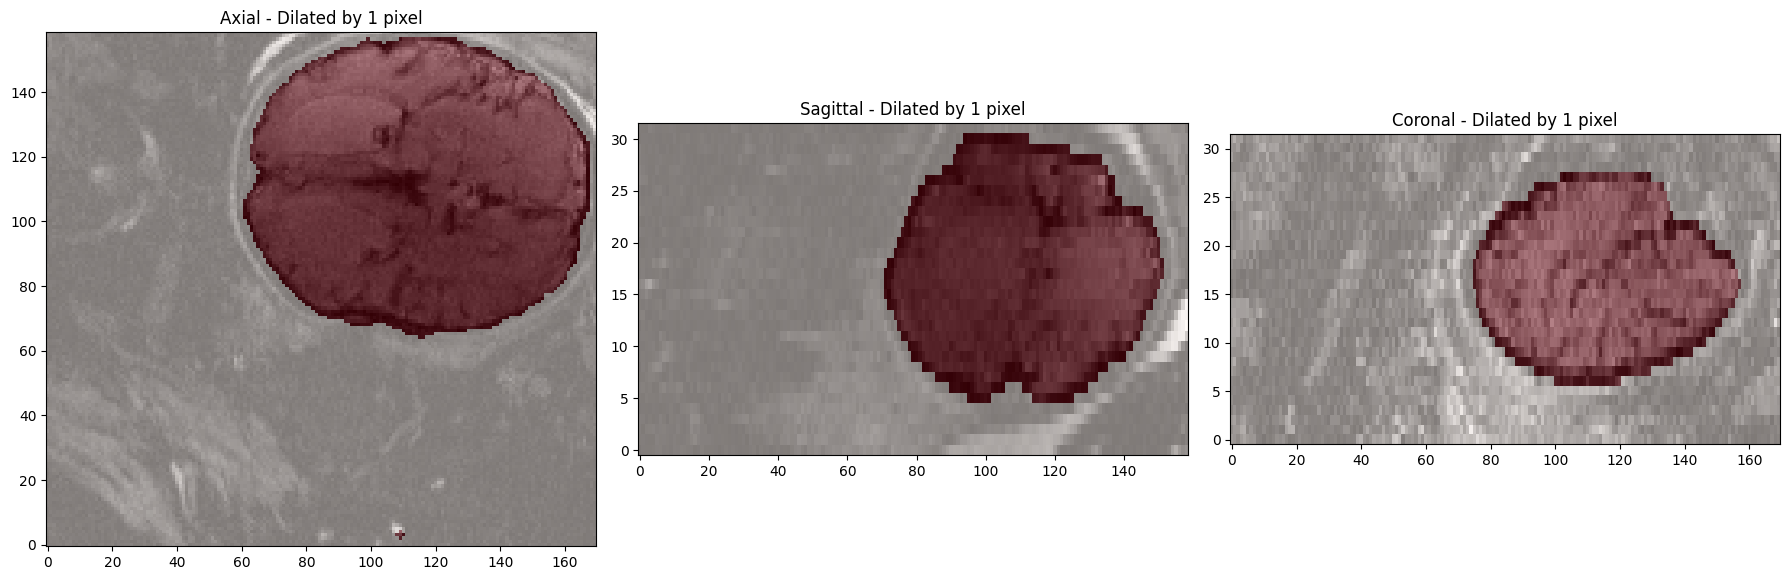

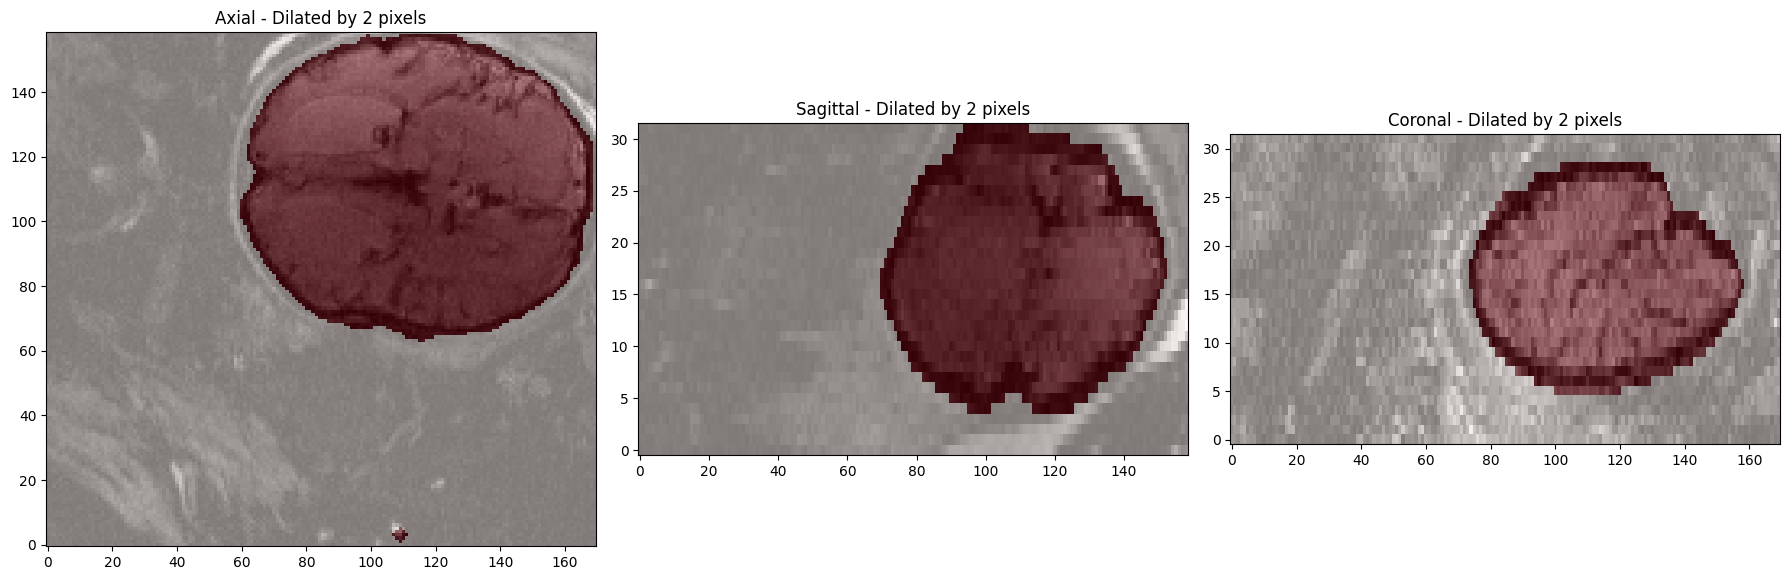

Processing complete. Results saved to: /data/disk_1/stu-projects/ezeji/server/processed_masks/


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure
import os

# We'll use just the first timepoint's mask since it's the same across time
base_mask = cropped_mask[..., 0].astype(bool)  # Ensure boolean type

# Then we define the structuring element (3D cross-shaped, connectivity=1)
structure = generate_binary_structure(3, 1)

print("Performing morphological operations...")
# Perform erosion by 1-2 pixels
eroded_mask_1 = binary_erosion(base_mask, structure=structure, iterations=1)
eroded_mask_2 = binary_erosion(base_mask, structure=structure, iterations=2)

# Perform dilation by 1-2 pixels
dilated_mask_1 = binary_dilation(base_mask, structure=structure, iterations=1)
dilated_mask_2 = binary_dilation(base_mask, structure=structure, iterations=2)

# Add the time dimension back
eroded_mask_1 = np.repeat(eroded_mask_1[..., np.newaxis], cropped_fmri.shape[-1], axis=-1)
eroded_mask_2 = np.repeat(eroded_mask_2[..., np.newaxis], cropped_fmri.shape[-1], axis=-1)
dilated_mask_1 = np.repeat(dilated_mask_1[..., np.newaxis], cropped_fmri.shape[-1], axis=-1)
dilated_mask_2 = np.repeat(dilated_mask_2[..., np.newaxis], cropped_fmri.shape[-1], axis=-1)

# Visualization setup
zooms = (1.0, 1.0, 3.0)  # Your actual voxel sizes (x, y, z)
axial_aspect = zooms[0] / zooms[1]   # 1.0
sagittal_aspect = zooms[2] / zooms[1] # 3.0
coronal_aspect = zooms[2] / zooms[0]  # 3.0

def compare_masks(original, modified, title):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Middle slices
    axial = original.shape[2] // 2
    sagittal = original.shape[0] // 2
    coronal = original.shape[1] // 2

    # Axial view
    axes[0].imshow(original[:, :, axial, 0].T,
                   cmap='gray', origin='lower', aspect=axial_aspect)
    axes[0].imshow(modified[:, :, axial, 0].T,
                   cmap='Reds', alpha=0.5, origin='lower', aspect=axial_aspect)
    axes[0].set_title(f'Axial - {title}')

    # Sagittal view
    axes[1].imshow(original[sagittal, :, :, 0].T,
                   cmap='gray', origin='lower', aspect=sagittal_aspect)
    axes[1].imshow(modified[sagittal, :, :, 0].T,
                   cmap='Reds', alpha=0.5, origin='lower', aspect=sagittal_aspect)
    axes[1].set_title(f'Sagittal - {title}')

    # Coronal view
    axes[2].imshow(original[:, coronal, :, 0].T,
                   cmap='gray', origin='lower', aspect=coronal_aspect)
    axes[2].imshow(modified[:, coronal, :, 0].T,
                   cmap='Reds', alpha=0.5, origin='lower', aspect=coronal_aspect)
    axes[2].set_title(f'Coronal - {title}')

    plt.tight_layout()
    plt.show()

# Generate visualizations
compare_masks(cropped_fmri, cropped_mask, "Original Mask")
compare_masks(cropped_fmri, eroded_mask_1, "Eroded by 1 pixel")
compare_masks(cropped_fmri, eroded_mask_2, "Eroded by 2 pixels")
compare_masks(cropped_fmri, dilated_mask_1, "Dilated by 1 pixel")
compare_masks(cropped_fmri, dilated_mask_2, "Dilated by 2 pixels")

# Save results
output_dir = '/data/disk_1/stu-projects/ezeji/server/processed_masks/'
os.makedirs(output_dir, exist_ok=True)

nib.save(nib.Nifti1Image(eroded_mask_1.astype(np.float32), fmri_img.affine),
         os.path.join(output_dir, 'eroded_1px.nii.gz'))
nib.save(nib.Nifti1Image(eroded_mask_2.astype(np.float32), fmri_img.affine),
         os.path.join(output_dir, 'eroded_2px.nii.gz'))
nib.save(nib.Nifti1Image(dilated_mask_1.astype(np.float32), fmri_img.affine),
         os.path.join(output_dir, 'dilated_1px.nii.gz'))
nib.save(nib.Nifti1Image(dilated_mask_2.astype(np.float32), fmri_img.affine),
         os.path.join(output_dir, 'dilated_2px.nii.gz'))

print("Processing complete. Results saved to:", output_dir)